# Shift fit evaluate goodness of fit

Cfr. shift fit 1 dev

This notebook
- calcs gof measures for the non-stationary distribution model (BIC, AIC, Deviance statistic) to compare model with and without scale changing
- calcs SE around estimate of return period of threshold (e.g. WBGT28) using delta method (try also profile likelihood!)

Some inspiratoin from Coles 2001

To do
- implement in main code to get gof of global fit 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


In [2]:
from scipy import stats
#import seaborn as sns

from statsmodels.nonparametric.smoothers_lowess import lowess


#import dist_cov # env = myenv where i installed dist_cov

sys.path.append('../dist_cov/dist_cov/')
import distributions_dev as distributions
#import sample as sample
import utils as utils 

In [3]:
start_message() 

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'TX99', 'method': 'empirical_percentile', 'time_method': 'single-year', 'shift_sigma': None, 'shift_period': None, 'chunk_version': 2, 'var': 'tasmax'}
var: tasmax
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc1041

# Fit model to a pixel 

and try to output value of log-likelihood 

In [4]:
# open gmst
# annual obs warming
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
df_gmst_obs_annual

,gmst
year,
1850,-0.060196
1851,0.057304
1852,0.094804
1853,0.052304
1854,0.062304
...,...
2019,1.234804
2020,1.264804
2021,1.109804


<Axes: xlabel='year'>

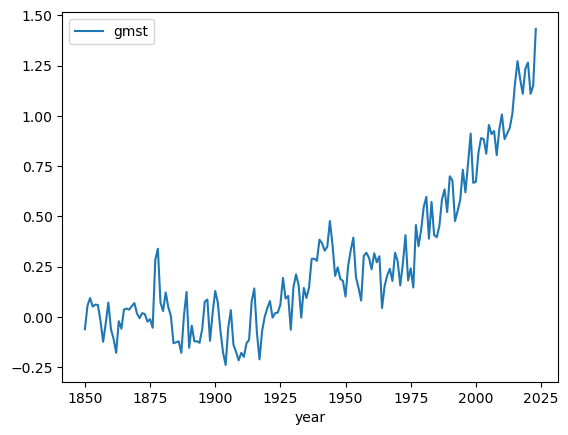

In [5]:
df_gmst_obs_annual.plot()

# spike in 1877: https://www.climate-lab-book.ac.uk/2016/spiralling-global-temperatures/

In [6]:
def apply_lowess(y, x=None, ntime=31):
    ''' y should be an xarray DataArray,
        x is used when provided, else falling back to standard indices
    '''
    # Squeeze (in case there is a dimension of size 1 that we don't need)
    y = y.squeeze()
    
    # Create a copy, plug in smoothed data later
    final = y.copy(deep=True)
    
    if x is None:
        x = np.arange(y.size)
    
    if not isinstance(y, np.ndarray):
        y = y.values

    # Apply LOWESS smoothing
    result = lowess(y, x, frac=ntime/y.size)
    
    x_smooth, y_smooth = result[:, 0], result[:, 1]
    
    # Ensure the smoothed result has the same length as the original data
    y_smooth_full = np.interp(x, x_smooth, y_smooth)

    # Assign the smoothed values back to the xarray DataArray
    final[:] = y_smooth_full[:]

    return final

# Example usage with your data
# gmst_ts = xr.DataArray(...)  # Load your DataArray
# smoothed_data = apply_lowess(gmst_ts.Ta, ntime=15*12)

<Axes: xlabel='year'>

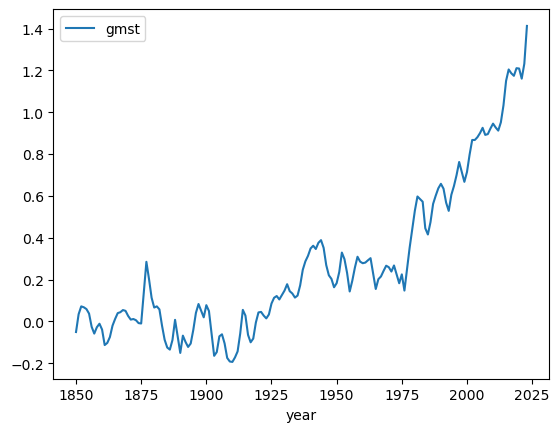

In [7]:
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
gmst_smo.plot()

## Open data: one pixel for Delhi

In [8]:
variable='wbgt'
dataset=datasets[0]
dirname='output_apr24-9139513' #'output_apr24-9110516' - put them in same folder!
dir1=os.path.join(scratchdirs, dirname, 'WBGT', 'ISIMIP3a', 'obsclim', dataset ) # if you always change flags metric you can also replace with fxn 
filepaths=get_filepaths(variable.upper(),dir1)

In [9]:
with xr.open_mfdataset(filepaths, engine='netcdf4') as ds:
    lat, lon = 28,77
    da_delhi = ds[str(variable)].sel(lat=lat, lon=lon, method='nearest').chunk({'time': -1}).compute()


In [10]:
da_delhi

<xarray.DataArray 'wbgt' (time: 43464)>
array([16.66319 , 16.832773, 16.74808 , ..., 13.003847, 11.634802,
       12.386272], dtype=float32)
Coordinates:
    lon      float32 77.25
    lat      float32 28.25
  * time     (time) datetime64[ns] 1901-01-01 1901-01-02 ... 2019-12-31

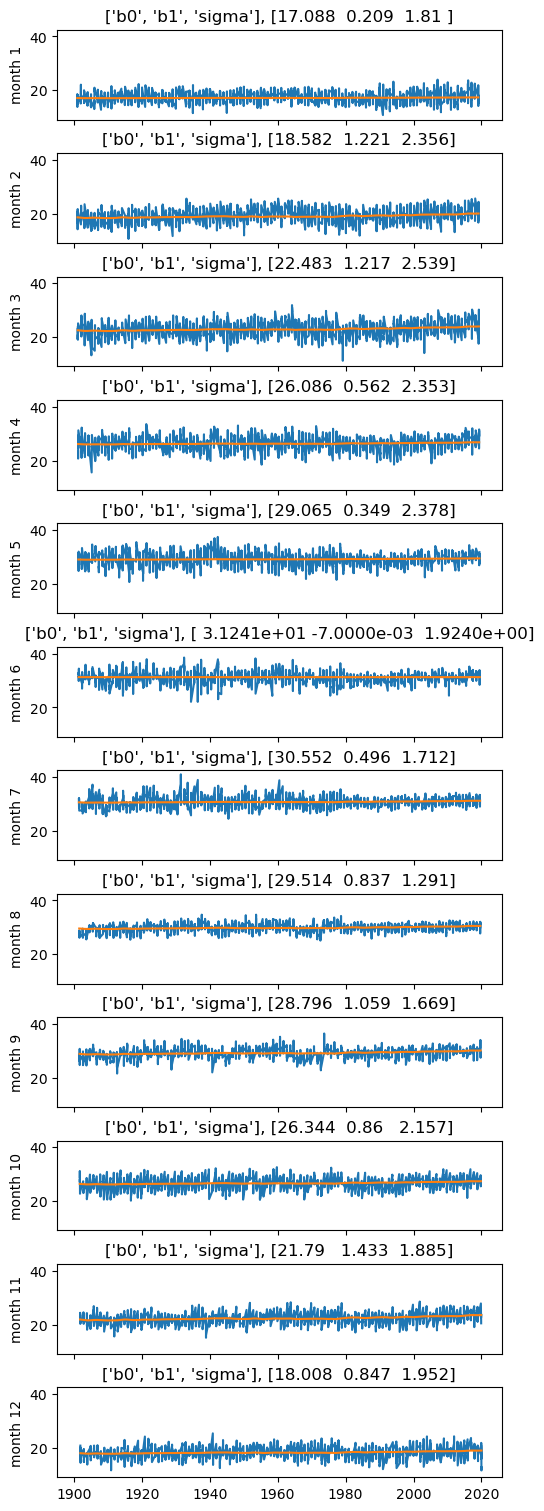

In [11]:
# monthly distribution shifting

fig, axes = plt.subplots(12,1,figsize=(5,15),layout='constrained', sharex=True, sharey=True)

arr_params = []
arr_loglike = []
arr_aic = []
arr_bic = []

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov(data=x, cov=cov)
    params_mle, loglike, inv_hess = dist.fit(return_loglike=True)
    predicted = dist.predict(params_mle, cov)

    # AIC=−2LL+2k
    # BIC=−2LL + klog(n)
    # here LL is the log-likelihood, k is the number of parameters, and n is the sample size.

    aic = -2*(-loglike) + 2*len(params_mle)
    bic = -2*(-loglike) + len(params_mle) * np.log(len(x))


    ax.plot(da.time, x)
    ax.plot(da.time, predicted)
    
    ax.set_title(f'{dist.param_names}, {np.round(params_mle, 3)}')
    ax.set_ylabel(f'month {j}')
    
    arr_params.append(params_mle)
    arr_loglike.append(loglike)

    arr_aic.append(aic)
    arr_bic.append(bic)
    
    
arr_params = np.array(arr_params)

In [12]:
arr_loglike # M0 log-likelihood

[7422.441005517208,
 7648.709002596006,
 8672.329994325766,
 8120.045152099825,
 8428.911912080433,
 7401.929354710021,
 7218.106981463785,
 6175.862544368582,
 6893.396805384182,
 8070.660720661095,
 7328.016829652421,
 7701.0757482465215]

In [13]:
arr_aic

[14850.882011034417,
 15303.418005192012,
 17350.659988651532,
 16246.09030419965,
 16863.823824160867,
 14809.858709420041,
 14442.21396292757,
 12357.725088737165,
 13792.793610768364,
 16147.32144132219,
 14662.033659304841,
 15408.151496493043]

In [14]:
arr_bic

[14869.521343127206,
 15321.777986675188,
 17369.29932074432,
 16264.631266823972,
 16882.463156253656,
 14828.399672044363,
 14460.853295020359,
 12376.364420829956,
 13811.334573392685,
 16165.96077341498,
 14680.574621929163,
 15426.790828585832]

In [15]:
inv_hess.todense()

array([[ 0.14378864, -0.10741396, -0.06857931],
       [-0.10741396,  0.08537698,  0.05055546],
       [-0.06857931,  0.05055546,  0.03370191]])

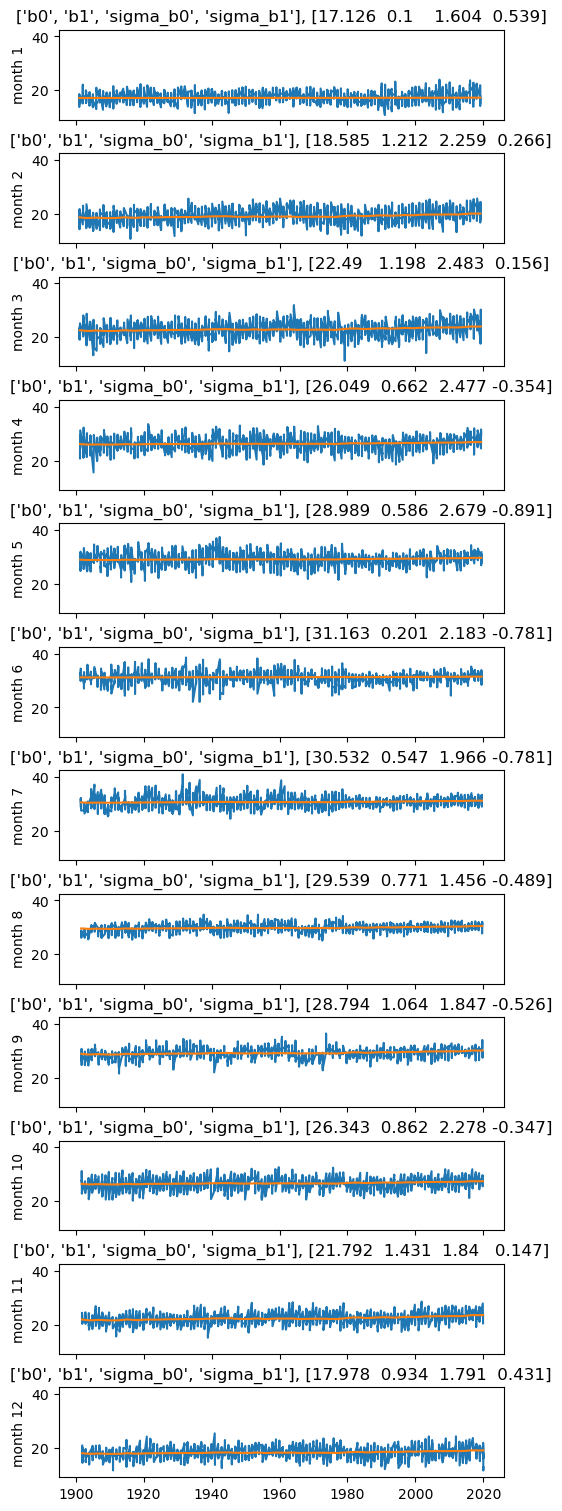

In [16]:
# monthly distribution shifting with scale also changing

fig, axes = plt.subplots(12,1,figsize=(5,15),layout='constrained', sharex=True, sharey=True)

arr_params_scale = []
arr_loglike_scale = []

arr_aic_sc = []
arr_bic_sc = []

# loop over months 
for j in range(1,13):
    ax=axes[j-1]
    
    da = da_delhi.sel(time=da_delhi['time.month'].isin([j]))
    x = da.values
    t = da.time.dt.year 
    cov = gmst_smo.loc[t.values].values.squeeze()
    
    dist = distributions.norm_cov_std(data=x, cov=cov)
    params_mle, loglike, inv_hess = dist.fit(return_loglike=True)
    predicted = dist.predict(params_mle, cov)

    # AIC=−2LL+2k
    # BIC=−2LL + klog(n)
    # here LL is the log-likelihood, k is the number of parameters, and n is the sample size.

    aic = -2*(-loglike) + 2*len(params_mle)
    bic = -2*(-loglike) + len(params_mle) * np.log(len(x))


    ax.plot(da.time, x)
    ax.plot(da.time, predicted)
    
    ax.set_title(f'{dist.param_names}, {np.round(params_mle, 3)}')
    ax.set_ylabel(f'month {j}')
    
    arr_params_scale.append(params_mle)
    arr_loglike_scale.append(loglike)

    arr_aic_sc.append(aic)
    arr_bic_sc.append(bic)
    
arr_params_scale = np.array(arr_params_scale)

In [17]:
arr_loglike_scale # M1

[7376.886513460398,
 7643.980444404052,
 8670.720622534136,
 8110.452202669263,
 8362.880787043785,
 7321.6426756180845,
 7106.352929106202,
 6109.589136003575,
 6847.547522459028,
 8058.611494402397,
 7325.515426225566,
 7679.2456006072025]

In [18]:
arr_aic_sc, arr_bic_sc

([14761.773026920797,
  15295.960888808104,
  17349.441245068272,
  16228.904405338526,
  16733.76157408757,
  14651.285351236169,
  14220.705858212405,
  12227.17827200715,
  13703.095044918056,
  16125.222988804793,
  14659.030852451133,
  15366.491201214405],
 [14786.625469711184,
  15320.440864119004,
  17374.29368785866,
  16253.625688837621,
  16758.614016877957,
  14676.006634735264,
  14245.558301002791,
  12252.030714797536,
  13727.816328417151,
  16150.07543159518,
  14683.752135950228,
  15391.343644004792])

In [19]:
# Deviance statistic 
# D = 2(loglike_1 - loglike_0)

# generally large values (alpha 0.05) compared X2 with df=1 
# meaning complex model considerably better 

arr_dev = 2 * (-np.array(arr_loglike_scale) + np.array(arr_loglike))
arr_dev

array([ 91.10898411,   9.45711638,   3.21874358,  19.18589886,
       132.06225007, 160.57335818, 223.50810472, 132.54681673,
        91.69856585,  24.09845252,   5.00280685,  43.66029528])

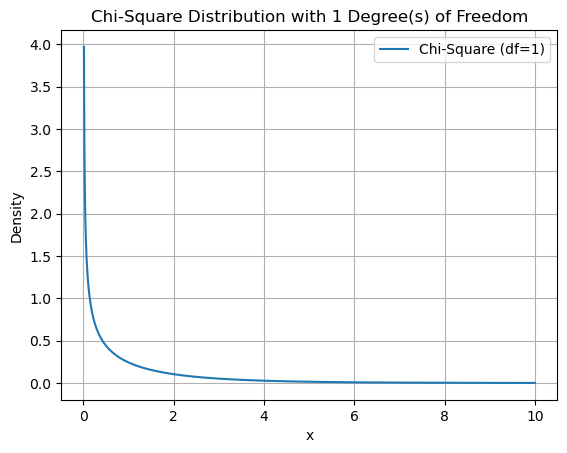

month 1: p-value: 0.0000
month 2: p-value: 0.0021
month 3: p-value: 0.0728
month 4: p-value: 0.0000
month 5: p-value: 0.0000
month 6: p-value: 0.0000
month 7: p-value: 0.0000
month 8: p-value: 0.0000
month 9: p-value: 0.0000
month 10: p-value: 0.0000
month 11: p-value: 0.0253
month 12: p-value: 0.0000


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def plot_chi_square(df):
    # Plot the chi-square distribution
    x = np.linspace(0, 10, 1000)
    plt.plot(x, chi2.pdf(x, df), label=f'Chi-Square (df={df})')

    #         plt.axvline(value, color='red', linestyle='--', label=f'Value = {value}, p-value = {p_value:.4f}')        

    plt.title(f'Chi-Square Distribution with {df} Degree(s) of Freedom')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage
df = 1
p_value = plot_chi_square(df)

for i,value in enumerate(arr_dev):
    p_value = 1 - chi2.cdf(value, df)
    print(f'month {i+1}: p-value: {p_value:.4f}' if p_value is not None else '')


# in all except month 3 more complex model is significantly better


In [21]:
 

# AIC 

# mostly negative, the more complex model is better

np.array(arr_aic_sc) - np.array(arr_aic)

array([ -89.10898411,   -7.45711638,   -1.21874358,  -17.18589886,
       -130.06225007, -158.57335818, -221.50810472, -130.54681673,
        -89.69856585,  -22.09845252,   -3.00280685,  -41.66029528])

In [22]:
np.array(arr_bic_sc) - np.array(arr_bic)

array([ -82.89587342,   -1.33712256,    4.99436711,  -11.00557799,
       -123.84913938, -152.39303731, -215.29499402, -124.33370603,
        -83.51824498,  -15.88534182,    3.17751402,  -35.44718458])

## Results 

Compared model with and without scale changing based on Deviance statistic (difference in log-likelihoods), as well as AIC and BIC. For most tests/months there is a significant improvement of including scale also changing: 11/12 models with dev statistic, 12/12 with AIC, 10/12 with BIC (which penalizes more the large sample size).

should i do different models for different pixels/months? or if for 2/3 of the months there is a significant improvement then I pick the more complex model? 

To do
- run this for all pixels, output the log-likelihood for each pixel/model. From this i can compute D, AIC and BIC (just miss len(x) for BIC but is the same for all pixels).
- Compare the already calculated shift fit models for different data, time periods + model complexity
- Get confidence intervals on p1, p0 

# Part 2: Get CI for estimate of probability using delta method (statsmodel)

Get variance of return period estimate using delta method

In [23]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.base.model import GenericLikelihoodModel


# Sample data
data = x #np.random.normal(loc=20, scale=5, size=1000)

# Define a log-likelihood function for normal distribution
class NormalModel(GenericLikelihoodModel):
    def loglike(self, params):
        mu, sigma = params[0], params[1]
        return np.sum(norm.logpdf(data, loc=mu, scale=sigma))

# Fit the model
model = NormalModel(data)
result = model.fit(start_params=[np.mean(data), np.std(data)])

# Get parameter estimates
mu_hat, sigma_hat = result.params

# Get the covariance matrix of the parameters
cov_matrix = result.cov_params()

# Return level (x_T)
return_level = 28
z_T = (return_level - mu_hat) / sigma_hat 

# Probability of exceedance (p)
p_hat = 1 - norm.cdf(z_T)

# Gradient vector for p
phi_z_T = norm.pdf(z_T)
grad_mu = phi_z_T / sigma_hat
grad_sigma = phi_z_T * z_T / sigma_hat
gradient = np.array([grad_mu, grad_sigma])

# Calculate variance of p using the Delta Method
var_p = gradient @ cov_matrix @ gradient.T

print(f"Estimated probability of exceedance (p_hat): {p_hat}")
print(f"Variance of the probability of exceedance (Var(p)): {var_p}")

# Confidence interval for the probability of exceedance
alpha = 0.05
z_alpha = norm.ppf(1 - alpha / 2)
ci_lower = p_hat - z_alpha * np.sqrt(var_p)
ci_upper = p_hat + z_alpha * np.sqrt(var_p)

print(f"95% confidence interval for probability of exceedance: ({ci_lower}, {ci_upper})")



Optimization terminated successfully.
         Current function value: 2.099098
         Iterations: 25
         Function evaluations: 54
Estimated probability of exceedance (p_hat): 4.6118341312517686e-07
Variance of the probability of exceedance (Var(p)): 1.3560687344939997e-14
95% confidence interval for probability of exceedance: (2.3294489311618506e-07, 6.894219331341687e-07)


In [24]:
cov_matrix


array([[ 1.0560354e-03, -3.4741336e-07],
       [-3.4741336e-07,  3.5341320e-04]], dtype=float32)

In [25]:
z_alpha

1.959963984540054

In [26]:
result.params

array([18.311872 ,  1.9741404], dtype=float32)

(array([  15.,   59.,  268.,  708., 1015.,  822.,  548.,  199.,   51.,
           4.]),
 array([11.63480186, 13.0139389 , 14.3930769 , 15.77221394, 17.15135193,
        18.53048897, 19.90962601, 21.28876305, 22.66790199, 24.04703903,
        25.42617607]),
 <BarContainer object of 10 artists>)

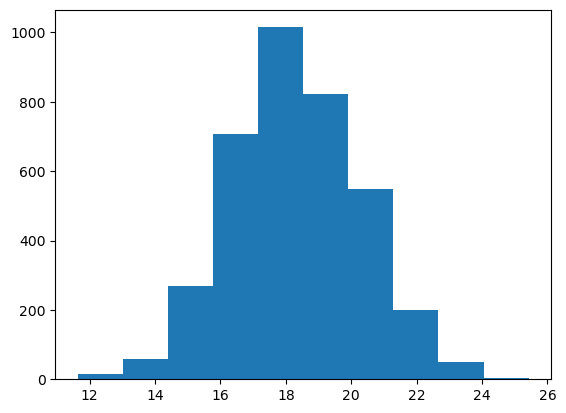

In [27]:
plt.hist(x)

## Test with scipy

In [29]:
dist = distributions.norm_cov(data=x, cov=cov)
params_mle, loglike, hess_inv = dist.fit(return_loglike=True)
predicted = dist.predict(params_mle, cov)

In [30]:
params_mle

array([18.0076777 ,  0.84704357,  1.95158979])

In [31]:
loglike

7701.0757482465215

In [32]:
hess_inv.todense()

array([[ 0.14378864, -0.10741396, -0.06857931],
       [-0.10741396,  0.08537698,  0.05055546],
       [-0.06857931,  0.05055546,  0.03370191]])

In [33]:
b0,b1,sigma_b0=params_mle
gmst_pres = float(gmst_smo.loc[2023])
gmst_pi = gmst_pres - 1.3
norm_pres=norm(loc=b0+b1*gmst_pres, scale=sigma_b0)
threshold = 25
print(norm_pres.sf(threshold)) # best estimate p of exceedance

0.0014908791447369113


/tmp/ipykernel_2580889/2703871260.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[2023])


In [34]:
# standardized value
cov_T = gmst_pres
mu_hat = b0+b1*cov_T
sigma_hat = sigma_b0
x_T = threshold
z_T = (x_T  - mu_hat ) / sigma_b0

# Probability of exceedance (p)
p_hat = 1 - norm.cdf(z_T)

# Gradient of p with respect to parameters (Delta method)
dmu_dbeta0 = 1
dmu_dbeta1 = cov_T
dp_dmu = -norm.pdf((x_T - mu_hat) / sigma_hat) / sigma_hat
dp_dsigma = (x_T - mu_hat) * norm.pdf((x_T - mu_hat) / sigma_hat) / sigma_hat**2

# Gradient vector
gradient = np.array([dp_dmu * dmu_dbeta0, dp_dmu * dmu_dbeta1, dp_dsigma])

# # Gradient of p with respect to parameters (Delta method)
# dmu_db0 = 1
# dmu_db1 = x_T
# dp_dmu = -norm.pdf(z_T) / sigma_hat
# dp_dsigma = (x_T - mu_hat) * norm.pdf((x_T - mu_hat) / sigma_hat) / sigma_hat**2

# # Gradient vector
# gradient = np.array([dp_dmu * dmu_db0, dp_dmu * dmu_db1, dp_dsigma])

# Variance of p using the Delta method
var_p = gradient.T @ hess_inv.todense() @ gradient
se_p = np.sqrt(var_p)  # Standard error of p

# Confidence interval for p
z = 1.96  # 95% confidence interval
# ci_lower = p_hat - ( z * se_p)
# ci_upper = p_hat + ( z * se_p)

# After calculating CI
ci_lower = max(0, p_hat - z * se_p)  # Ensure lower bound is not negative
ci_upper = min(1, p_hat + z * se_p)  # Ensure upper bound does not exceed 1

print(f"Estimated probability of exceedance (p_hat): {p_hat}")
print(f"Variance of the probability of exceedance (Var(p)): {var_p}")
print(f"95% confidence interval for probability of exceedance: [{ci_lower}, {ci_upper}]")

Estimated probability of exceedance (p_hat): 0.0014908791447368896
Variance of the probability of exceedance (Var(p)): 1.7988222303822446e-06
95% confidence interval for probability of exceedance: [0, 0.004119634645013861]


In [35]:
se_p

0.0013412017858555978

In [36]:
hess_inv # old hess_inv from BFGS ! 

<3x3 LbfgsInvHessProduct with dtype=float64>

In [37]:
hess_inv.todense()

array([[ 0.14378864, -0.10741396, -0.06857931],
       [-0.10741396,  0.08537698,  0.05055546],
       [-0.06857931,  0.05055546,  0.03370191]])

In [38]:
gradient

array([-0.00248649, -0.00351337,  0.00738392])

### calc CI on difference d = p1-p0

In [41]:



beta0_hat, beta1_hat, sigma_hat = params_mle # MLE estimates
# Inverse Hessian (covariance matrix)

# Covariate values and threshold
cov_T1 = gmst_pres 
cov_T2 = gmst_pres - 1.3 
x_T = 22

# Calculate mu for the given covariate values
mu_hat1 = beta0_hat + beta1_hat * cov_T1
mu_hat2 = beta0_hat + beta1_hat * cov_T2

# Calculate probabilities of exceedance
p_hat1 = 1 - norm.cdf((x_T - mu_hat1) / sigma_hat)
p_hat2 = 1 - norm.cdf((x_T - mu_hat2) / sigma_hat)

# Difference between probabilities
d_hat = p_hat1 - p_hat2

# Gradient calculation for p_1 and p_2
grad_p1 = np.array([
    -norm.pdf((x_T - mu_hat1) / sigma_hat) / sigma_hat, 
    -norm.pdf((x_T - mu_hat1) / sigma_hat) / sigma_hat * cov_T1,
    (x_T - mu_hat1) * norm.pdf((x_T - mu_hat1) / sigma_hat) / sigma_hat**2
])

grad_p2 = np.array([
    -norm.pdf((x_T - mu_hat2) / sigma_hat) / sigma_hat, 
    -norm.pdf((x_T - mu_hat2) / sigma_hat) / sigma_hat * cov_T2,
    (x_T - mu_hat2) * norm.pdf((x_T - mu_hat2) / sigma_hat) / sigma_hat**2
])

# Gradient of the difference
grad_d = grad_p1 - grad_p2

# Variance of the difference
variance_d = grad_d.T @ hess_inv.todense() @ grad_d
se_d = np.sqrt(variance_d)

# Confidence interval for the difference
z = 1.96  # 95% confidence interval
ci_lower = d_hat - z * se_d
ci_upper = d_hat + z * se_d


print(f"Estimated difference probability of exceedance (d_hat): {d_hat}")
print(f"Variance of the difference (Var(d)): {variance_d}")
print(f"95% confidence interval for the difference in probability of exceedance: [{ci_lower}, {ci_upper}]")

Estimated difference probability of exceedance (d_hat): 0.053081949997347166
Variance of the difference (Var(d)): 6.610535280471518e-05
95% confidence interval for the difference in probability of exceedance: [0.03714613111865148, 0.06901776887604286]
